In [17]:
import datetime
import os

import sys

sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master')
sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master/src')

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from dataset import OzeDataset
from benchmark import LSTM
from utils import compute_loss
from visualization import plot_visual_sample
from visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [18]:
import importlib
import warnings
spec = importlib.util.find_spec("ABBA")
if spec is None:
    warnings.warn("Try: pip install -r 'requirements.txt'")
from ABBA import ABBA as ABBA
import numpy as np
import time

In [19]:
# Training parameters
DATASET_PATH = 'dataset/dataset.npz'
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 2e-4
EPOCHS = 30

# Model parameters
K = 672 # Time window length
d_model = 64 # Lattent dim
n_layer = 4 # Number of LSTM layers

d_input = 37 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")



Using device cuda:0


In [20]:
dataset = np.load(DATASET_PATH)

ozeDataset = OzeDataset(DATASET_PATH)

dataset_train_orig, dataset_val_orig, dataset_test_orig = random_split(ozeDataset, (5500, 1000, 1000))

trainlist = list(range(0, 5500))
vallist = list(range(0, 1000))
testlist = list(range(0, 1000))

dataset_train = torch.utils.data.Subset(dataset_train_orig, trainlist)
dataset_val = torch.utils.data.Subset(dataset_val_orig, vallist)
dataset_test = torch.utils.data.Subset(dataset_test_orig, testlist)


dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

In [21]:
# Load transformer with Adam optimizer and MSE loss function
net = LSTM(d_input, d_model, d_output, n_layer).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [22]:
xcol = []
ycol = []

for index, (x, y) in enumerate(dataloader_train):
    xcol += x
    ycol += y
    
    lastx = x
    lasty = y
#     print(x.size())

# print(lasty.size())

[Epoch  30/30]: 100%|██████████| 5500/5500 [02:20<00:00, 39.17it/s, loss=0.00222, val_loss=0.00216]


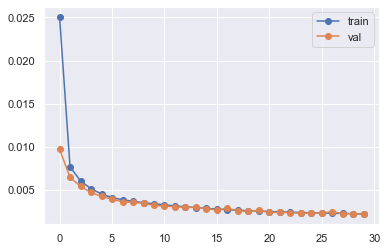

In [23]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
_ = plt.legend()



In [30]:
_ = net.eval()

In [31]:
# plot_visual_sample(dataloader_test, net, device)
# plt.savefig("fig")

In [32]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 250/250 [00:19<00:00, 12.75it/s]


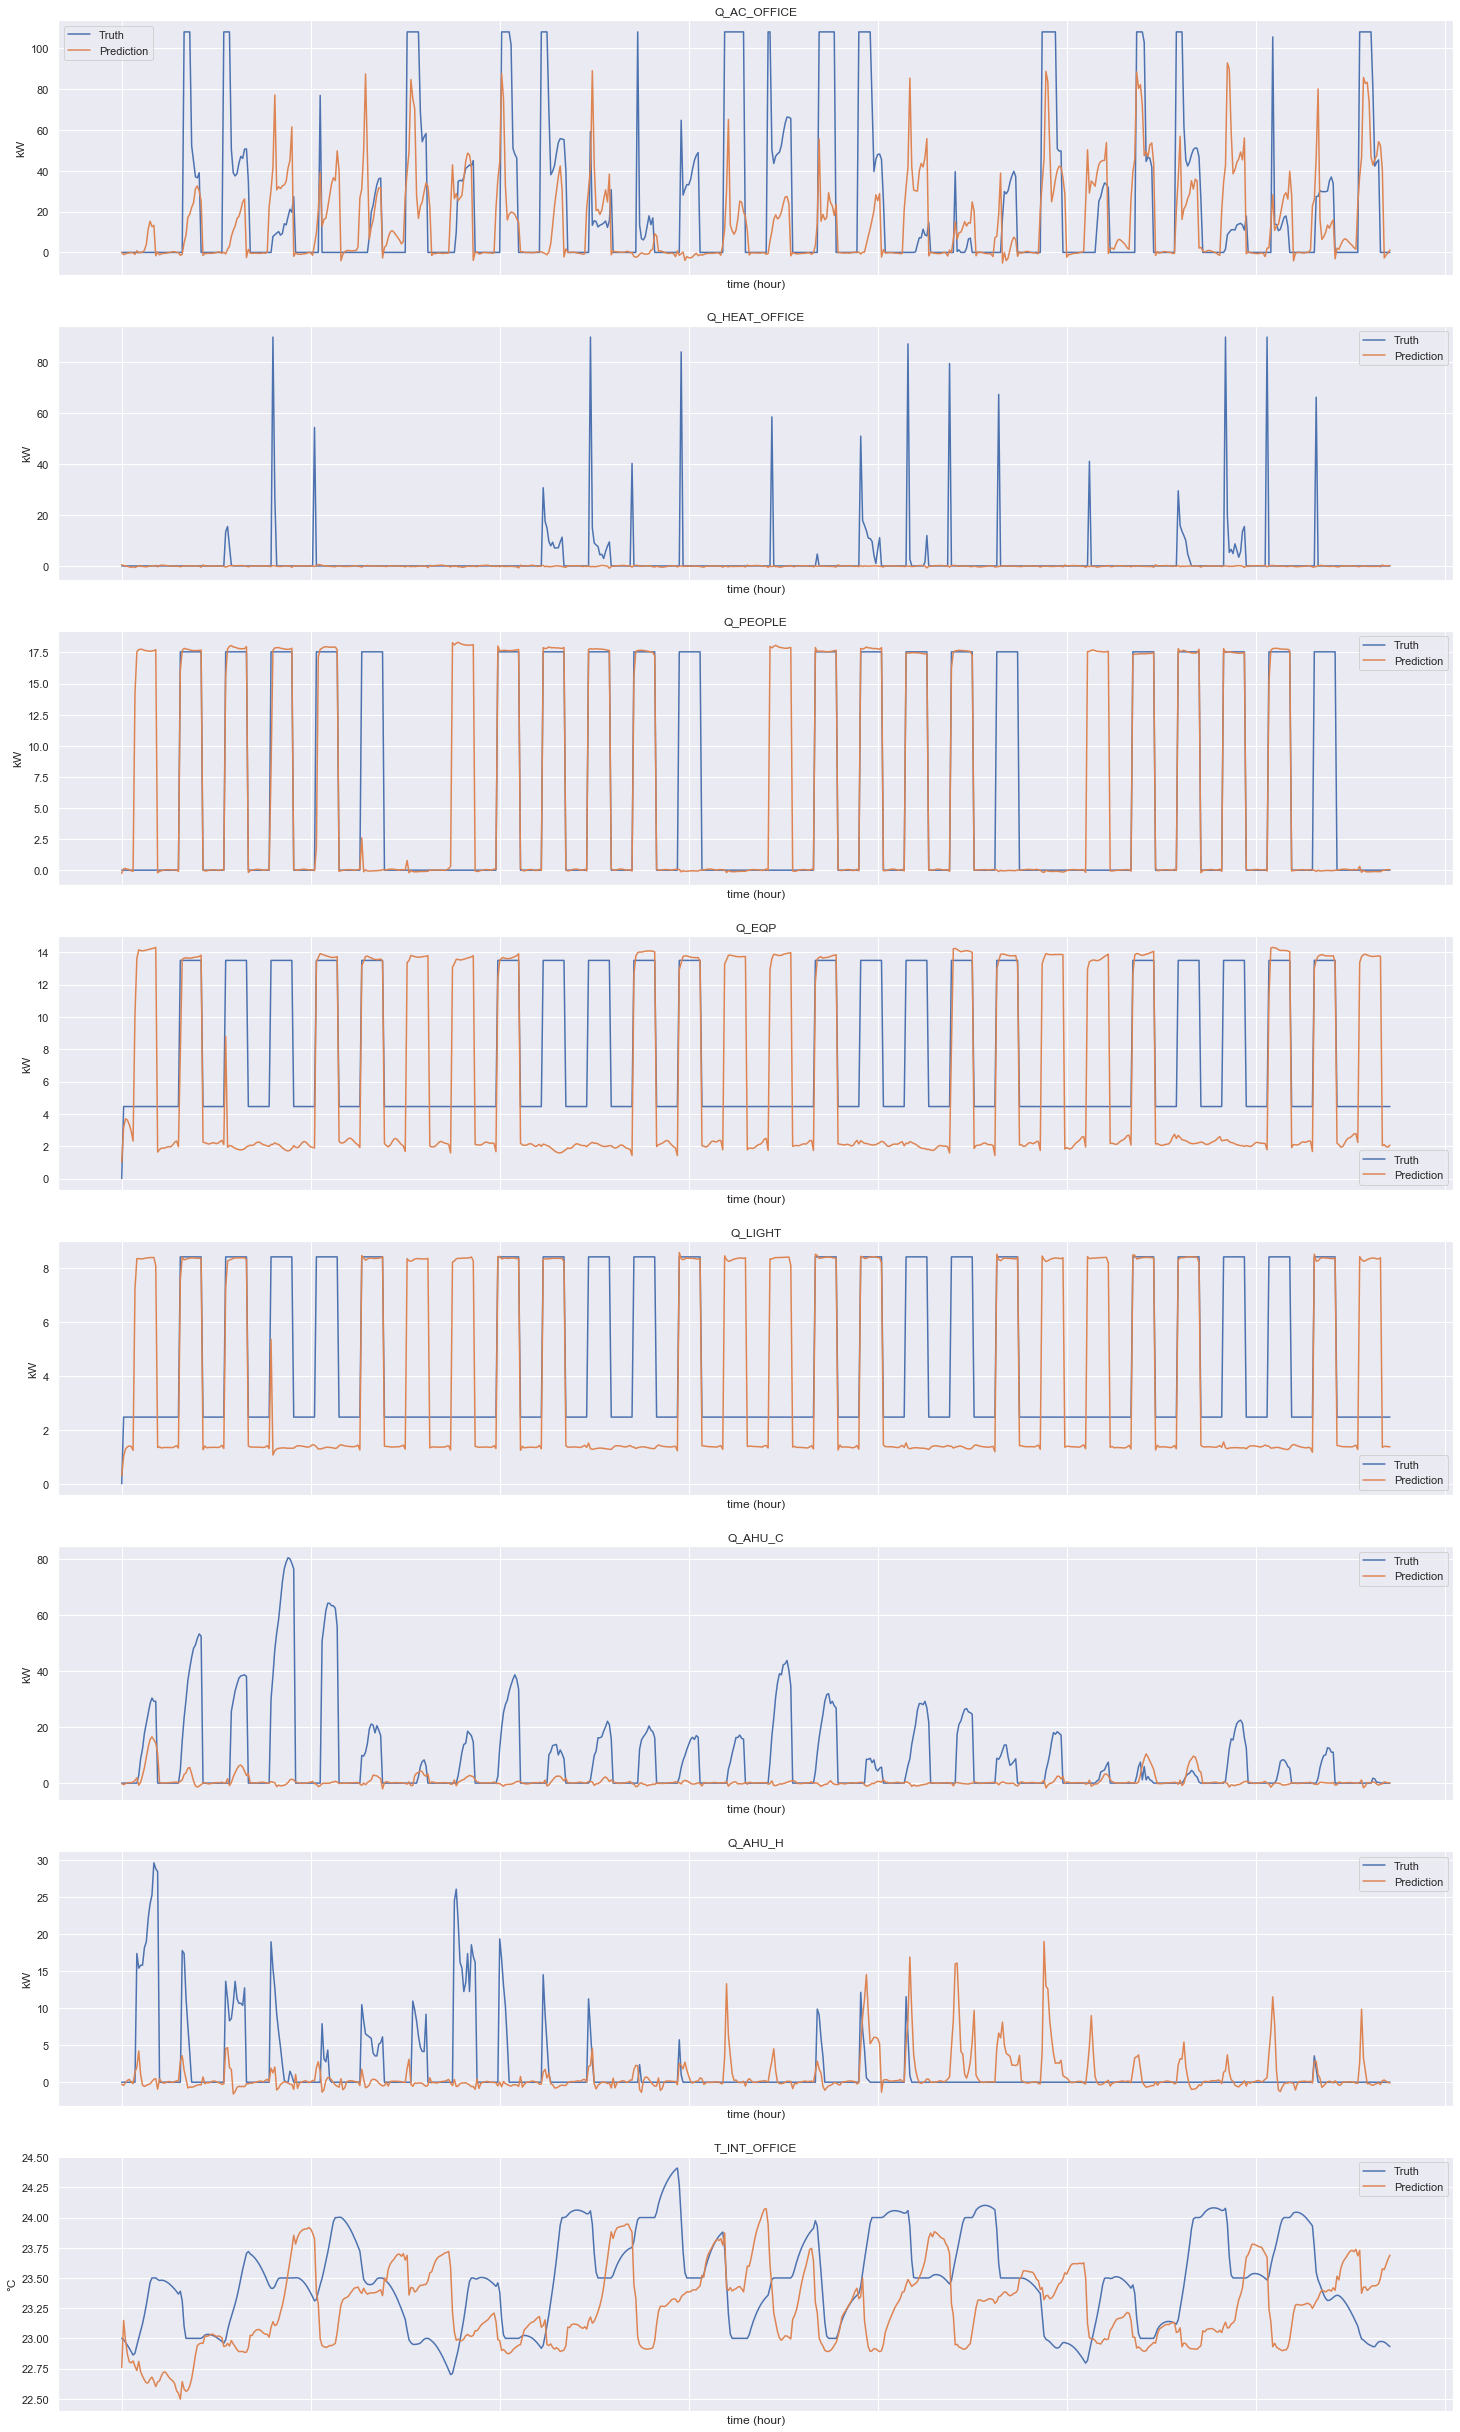

In [33]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

Plot error distributions

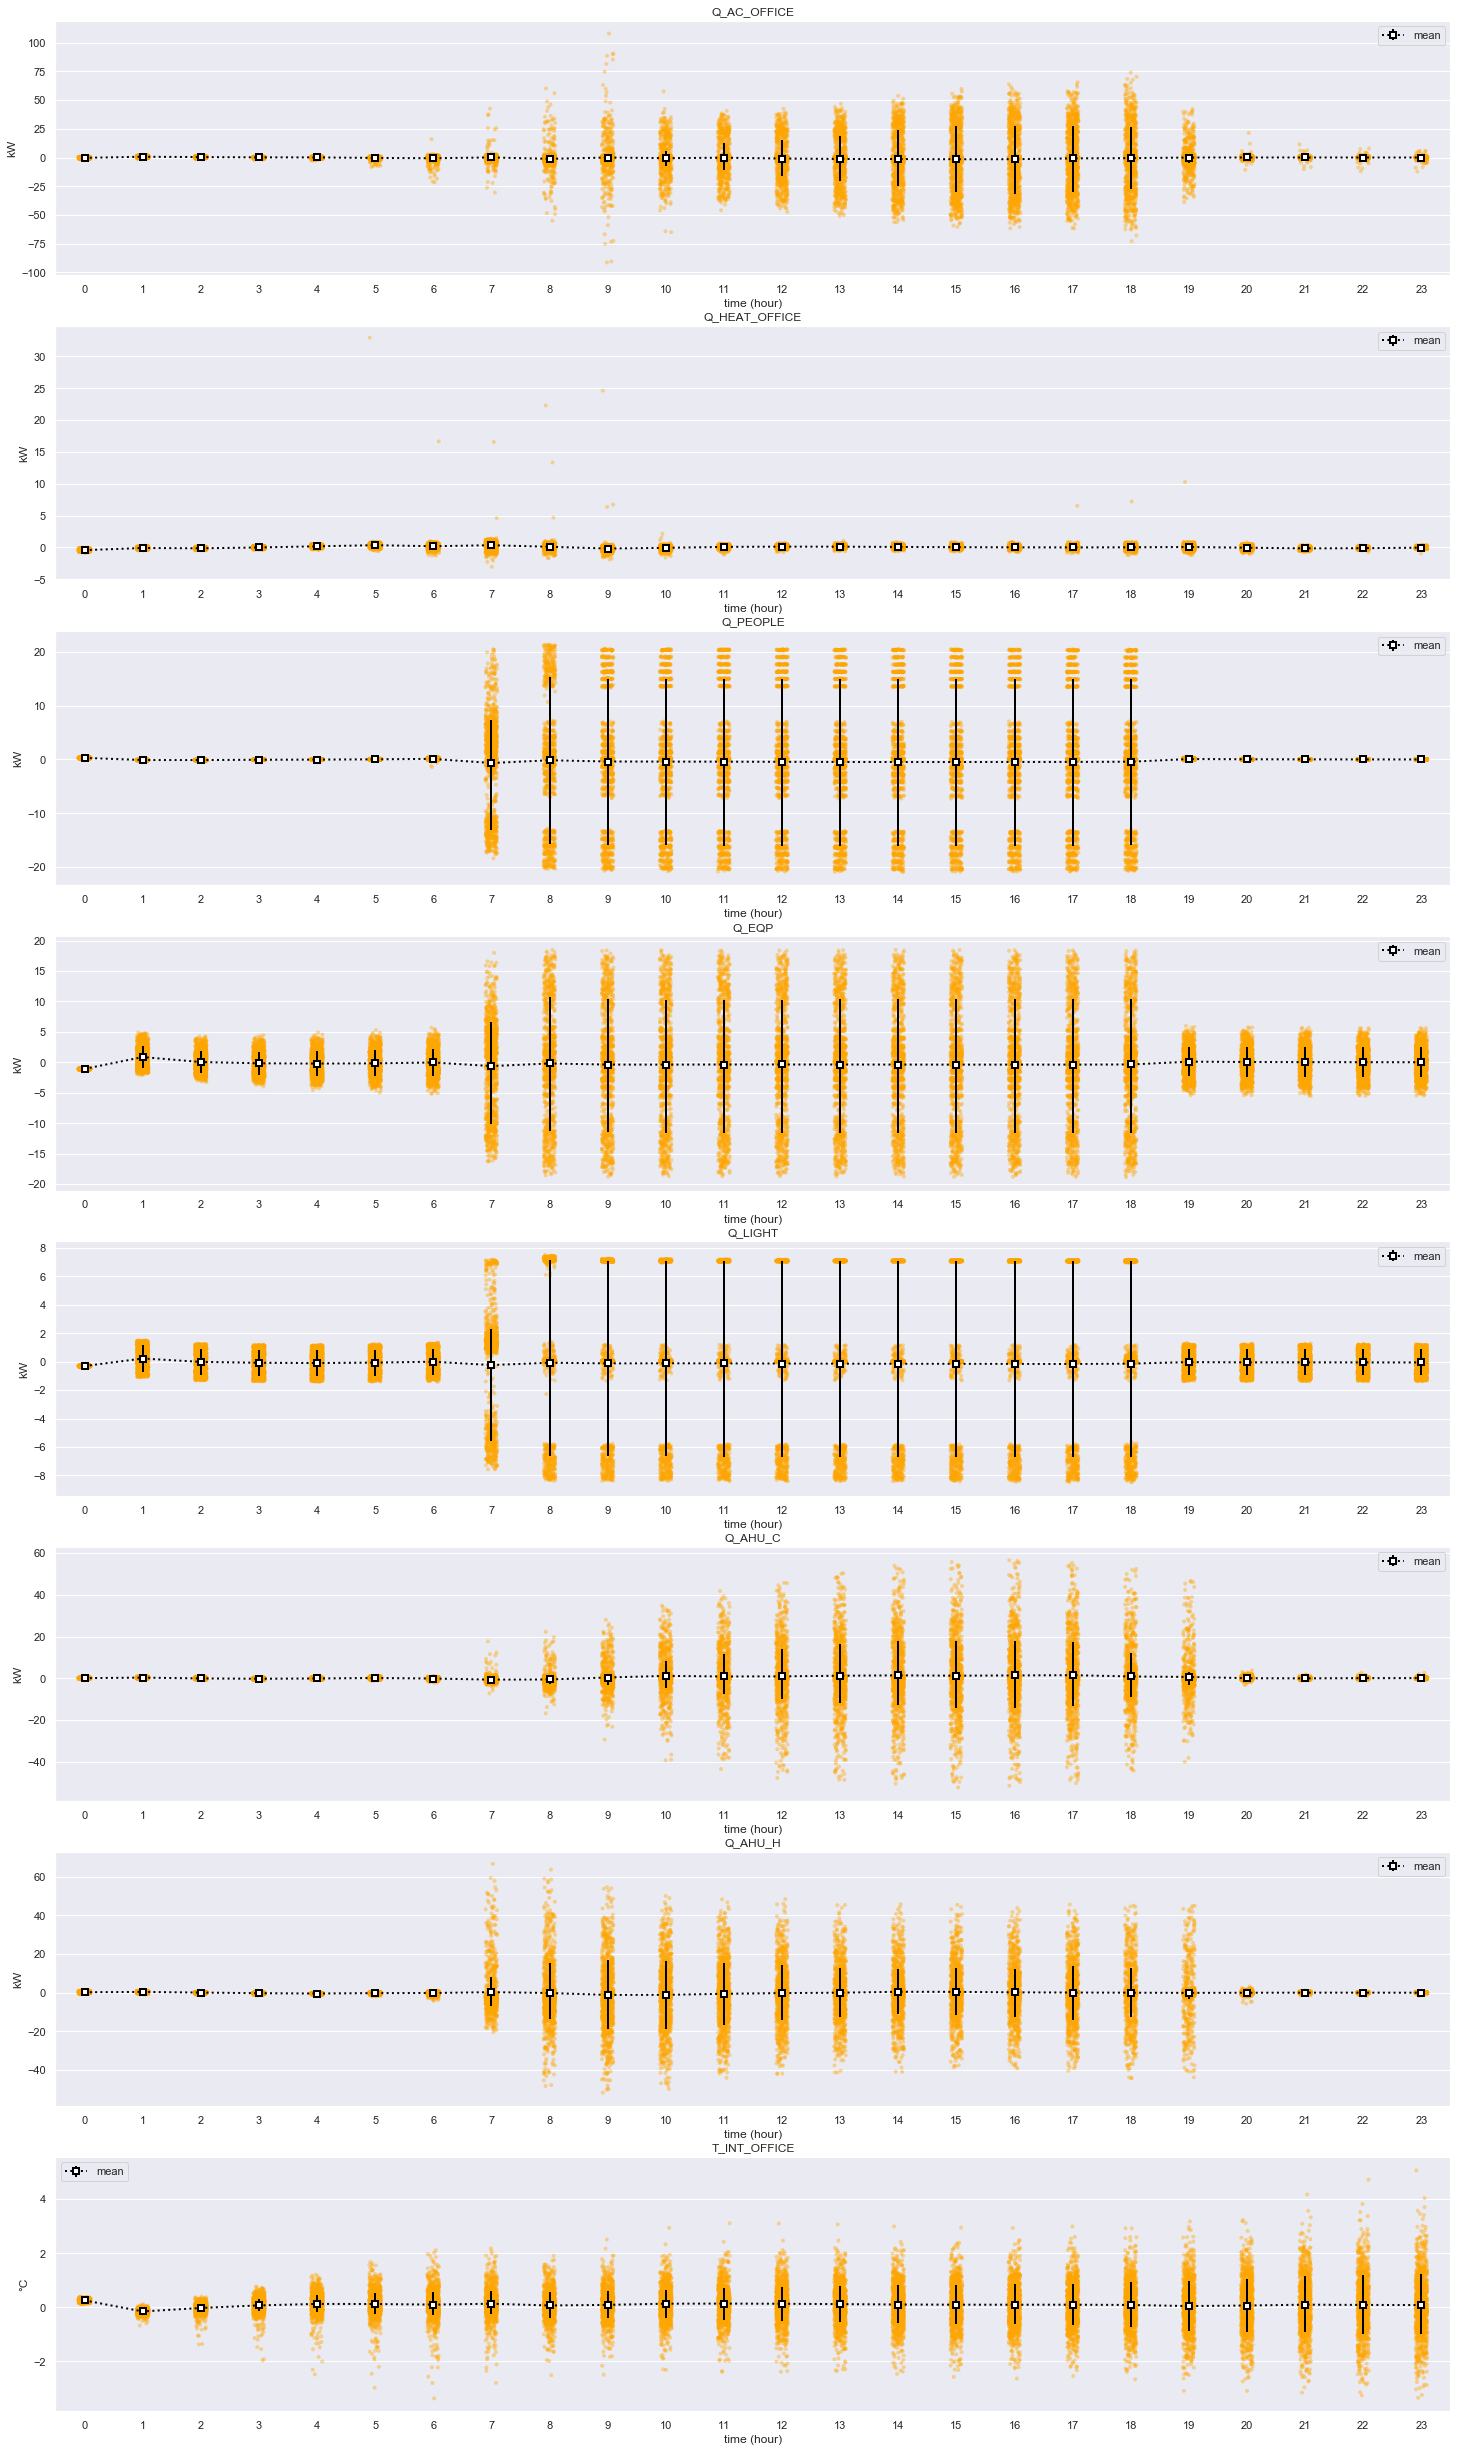

In [34]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)

In [35]:
# print(ozeDataset._y)
expected = ozeDataset._y.numpy()

time_limit = ozeDataset._y.shape[1]
labels = ozeDataset.labels['X']
# print(time_limit)
# print(labels)

forecast_errors = np.zeros((672,8))
for label in labels:
    idx_label = ozeDataset.labels['X'].index(label)
#     print(idx_label)
    y_pred = predictions[:, :time_limit, idx_label]
    y_true = expected[:, :time_limit, idx_label]
    forecast_errors += expected[idx_label]-predicted[idx_label]

# print(forecast_errors)
mean_forecast_error = np.mean(forecast_errors)
mean_squared_error = np.mean(forecast_errors**2)

print("Mean Forecast Error :" + str(mean_forecast_error))
print("Mean Squared Forecast Error :" + str(mean_squared_error))


NameError: name 'predicted' is not defined